## 1. обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.datasets import fashion_mnist

# keras.losses.SparseCategoricalCrossentropy()
from tensorflow.keras.losses import categorical_crossentropy
# tensorflow.keras.metrics.accuracy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [3]:
# загрузка тренировочных и тестовых данных
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255 
x_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

In [4]:
labels = {
        0: 'футболка',
        1: 'брюки',
        2: 'свитер',
        3: 'платье',
        4: 'куртка',
        5: 'сандалии',
        6: 'рубашка',
        7: 'кроссовки',
        8: 'сумка',
        9: 'ботинки',
            }
len(labels)

10

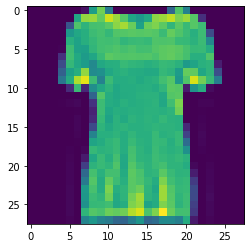

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Это футболка


In [5]:
N = 10
plt.imshow(x_train[N,:,:])
plt.show()
label = np.argmax(y_train[N], axis = 0)
print(y_train[N])
print(f'Это {labels[label]}')

In [6]:
x_train[202,150:160]

array([], shape=(0, 28, 1), dtype=float32)

In [7]:
# Размер набора данных для обучения
x_train.shape

(60000, 28, 28, 1)

### Соберем сеть как на занятии

In [8]:
batch_size=32
epochs = 5
num_predictions = 20
results = []

In [9]:
# конфигурирование слоев нейросети
name='base_model'
model = Sequential(name=name)

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels)))
model.add(Activation('softmax'))

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              verbose=0)

In [10]:
model.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        1

In [11]:
# сохранение модели и весов
save_dir = '/home/mitko/Projects/Neural_networks/lesson4'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

INFO:tensorflow:Assets written to: /home/mitko/Projects/Neural_networks/lesson4/base_model/assets
сохранить обученную модель как /home/mitko/Projects/Neural_networks/lesson4/base_model 


In [12]:
# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
# results.append([name, scores[0], scores[1]])
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 3s 9ms/step - loss: 0.4087 - accuracy: 0.8512
Test loss: 0.40868136286735535
Test accuracy: 0.8511999845504761


Сделаем предикт для примеров тестов

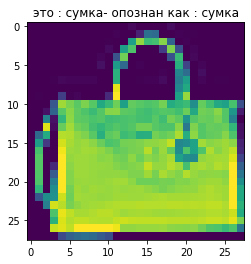

In [13]:
N = 30
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+labels[y_t[0]]+'- опознан как : '+labels[y_i[0]])
plt.show()

### 2. Оценить рост точности при увеличении ширины сети (больше ядер)

In [14]:
kernel = [2, 4, 8, 16, 32, 64]

2_kernel_model
Test loss: 0.6499028205871582
Test accuracy: 0.7616000175476074
4_kernel_model
Test loss: 0.4975893199443817
Test accuracy: 0.8256999850273132
8_kernel_model
Test loss: 0.4368724226951599
Test accuracy: 0.8428000211715698
16_kernel_model
Test loss: 0.4045770466327667
Test accuracy: 0.8535000085830688
32_kernel_model
Test loss: 0.3787732720375061
Test accuracy: 0.859000027179718
64_kernel_model
Test loss: 0.37905555963516235
Test accuracy: 0.8621000051498413


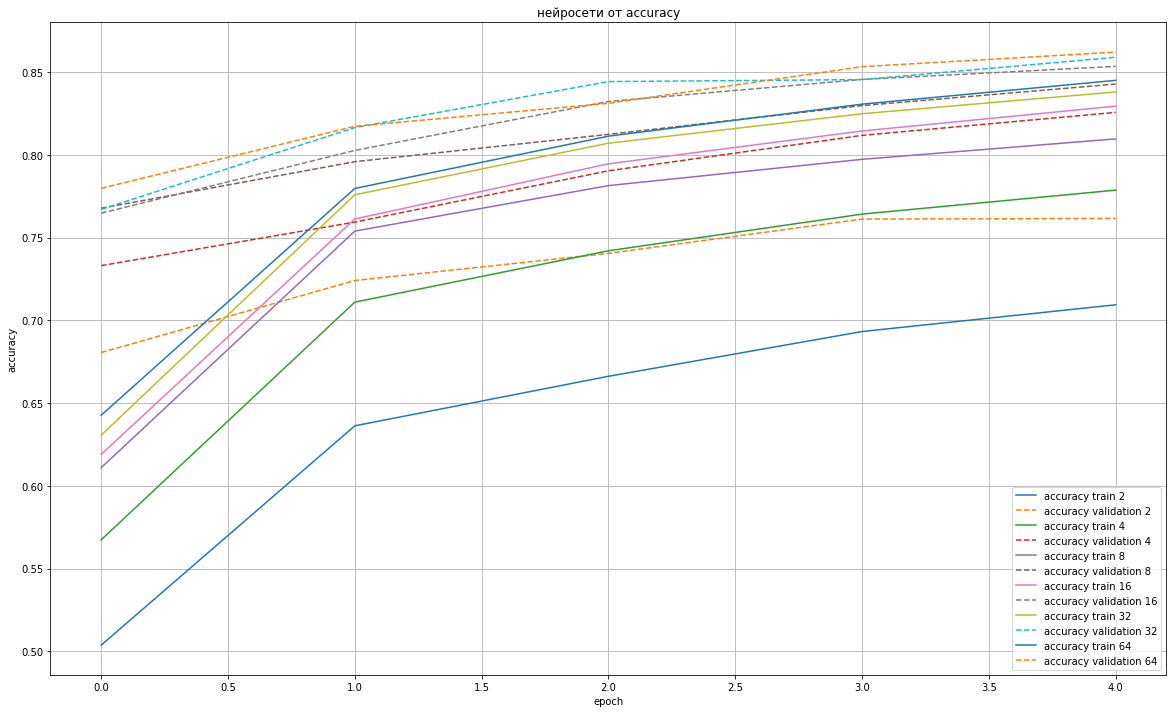

In [15]:
plt.figure(figsize=(20,12))

for k in kernel:
    name=f'{k}_kernel_model'
    print(name)
    model = Sequential(name=name)

    # слои нейросети отвественные за свертку и max-pooling
    model.add(Conv2D(k, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(k, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout( 0.25))

    model.add(Conv2D(2*k, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(2*k, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # полносвязные слои нейронной сети
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels)))
    model.add(Activation('softmax'))

    # компиляция модели
    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])

    model_history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  verbose=0)
    
    scores = model.evaluate(x_test, y_test, verbose=0)
    results.append([name, scores[0], scores[1]])
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    
    plt.plot(model_history.history['accuracy'], '-', label = f'accuracy train {k}')
    plt.plot(model_history.history['val_accuracy'], '--', label = f'accuracy validation {k}')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [16]:
pd.DataFrame(results, columns=['name', 'test loss', 'test accuracy']).sort_values(by='test accuracy')

,name,test loss,test accuracy
0,2_kernel_model,0.649903,0.7616
1,4_kernel_model,0.497589,0.8257
2,8_kernel_model,0.436872,0.8428
3,16_kernel_model,0.404577,0.8535
4,32_kernel_model,0.378773,0.8590
5,64_kernel_model,0.379056,0.8621


### Полученный результат показывает, что с увеличением числа карт признаков точность модели растет.

## 3. Оценить рост точности при увеличении глубины сети (больше слоев)

### Так как значения accuracy в предыдущем эксперименте практически одинаковые для 16б 32 и 64 ядер, то для ускорения расчетов примем за начальное значение - 16 ядер. Кроме того, опытным путем было определено, что для датасета fashion_mnist не стоит добавлять больше 3 стеков.

In [17]:
max_stack_num = 3
kernel = 16
results2 = []

1_stack_model
Model: "1_stack_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
activation_42 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 26, 26, 16)        2320      
_________________________________________________________________
activation_43 (Activation)   (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 270

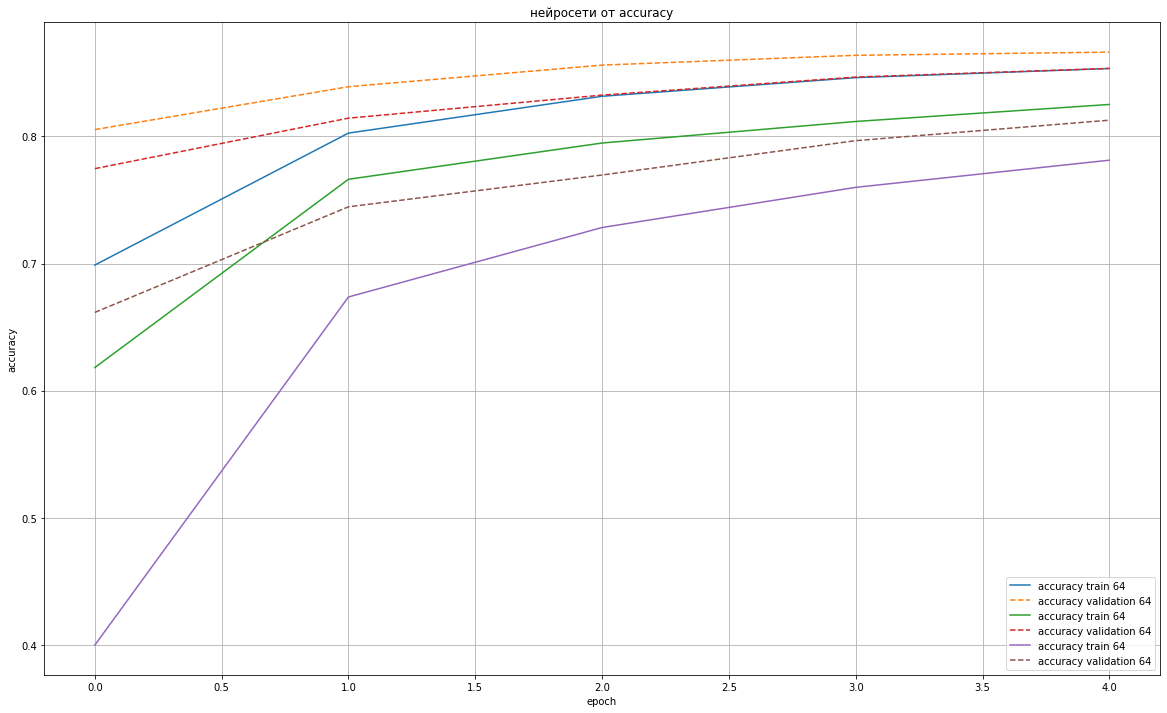

In [18]:
plt.figure(figsize=(20,12))

for num in range(1, max_stack_num+1):
    name=f'{num}_stack_model'
    print(name)
    model = Sequential(name=name)
    for n in range(num):
        # слои нейросети отвественные за свертку и max-pooling
        model.add(Conv2D(kernel*(2**n), (3, 3), padding='same',
                         input_shape=x_train.shape[1:]))
        model.add(Activation('relu'))
        model.add(Conv2D(kernel*(2**n), (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout( 0.25))

    # полносвязные слои нейронной сети
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels)))
    model.add(Activation('softmax'))
    
    model.summary()

    # компиляция модели
    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])

    model_history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  verbose=0)
    
    scores = model.evaluate(x_test, y_test, verbose=0)
    results2.append([name, scores[0], scores[1]])
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    
    plt.plot(model_history.history['accuracy'], '-', label = f'accuracy train {k}')
    plt.plot(model_history.history['val_accuracy'], '--', label = f'accuracy validation {k}')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [19]:
pd.DataFrame(results2, columns=['name', 'test loss', 'test accuracy']).sort_values(by='test accuracy')

,name,test loss,test accuracy
2,3_stack_model,0.497968,0.8127
1,2_stack_model,0.402432,0.8534
0,1_stack_model,0.366920,0.8662


### Тут получили лучший результат при всего 1 стеке.

## 4. Сравнить с точностью полносвязной сети для этой выборки

### Результаты моего исследования полносвязной сети по ссылке: https://github.com/myselfadmirer/Neural_networks/blob/main/lesson2/lesson2.ipynb

### Возьмем лучшую модель (1 стек и 64 карты признаков) и сформируем для нее матрицу ошибок, как в дз2 для полносвязной сети.

In [20]:
# plt.figure(figsize=(20,12))

kernrl = 64
epochs = 15 #как в примере с полносвязной сетью

name='result_model'
print(name)
model = Sequential(name=name)

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(kernel, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(kernel, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels)))
model.add(Activation('softmax'))

model.summary()

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model_history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              verbose=0)

scores = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# plt.plot(model_history.history['accuracy'], '-', label = f'accuracy train {k}')
# plt.plot(model_history.history['val_accuracy'], '--', label = f'accuracy validation {k}')
        
# plt.legend()
# plt.grid('On')
# plt.title('нейросети от accuracy')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.show()

result_model
Model: "result_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
activation_60 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 26, 26, 16)        2320      
_________________________________________________________________
activation_61 (Activation)   (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2704)

In [34]:
predictions = model.predict(x_test)

y_predict = np.argmax(predictions, axis=1)
print(y_predict[:10])

print(y_test[:10])

[9 2 1 1 6 1 4 6 5 7]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


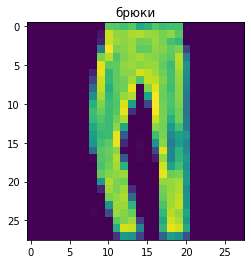

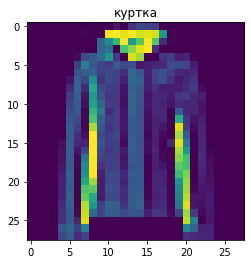

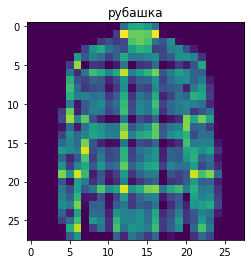

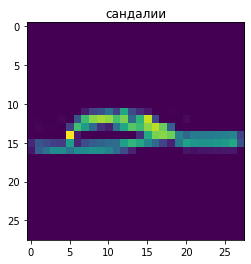

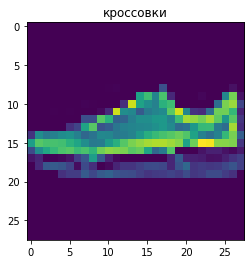

In [30]:
for n in range(5, 10):
    plt.imshow(x_test[n,:,:])
    plt.title(labels[y_predict[n]])
    plt.show()

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_predict)
cnf_matrix

array([[869,   0,  19,  35,   3,   2,  63,   0,   9,   0],
       [  2, 970,   0,  19,   2,   0,   5,   0,   2,   0],
       [ 12,   0, 881,  11,  53,   0,  43,   0,   0,   0],
       [ 13,   2,   8, 937,  20,   0,  17,   0,   3,   0],
       [  1,   1, 114,  43, 792,   0,  48,   0,   1,   0],
       [  0,   0,   0,   0,   0, 962,   0,  23,   0,  15],
       [154,   0, 103,  32,  68,   0, 634,   0,   9,   0],
       [  0,   0,   0,   0,   0,   6,   0, 968,   0,  26],
       [  2,   1,   4,   5,   2,   1,   2,   5, 978,   0],
       [  0,   0,   0,   0,   0,   3,   1,  33,   0, 963]])

In [47]:
report = classification_report(np.argmax(y_test, axis=1), y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.78      0.88      0.83      1000
           3       0.87      0.94      0.90      1000
           4       0.84      0.79      0.82      1000
           5       0.99      0.96      0.97      1000
           6       0.78      0.63      0.70      1000
           7       0.94      0.97      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000
weighted avg       0.90      0.90      0.89     10000



In [50]:
with open ('report.txt', 'r') as r:
    report_hw_2 = r.read()

print(report_hw_2)

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1000
           1       0.97      0.97      0.97      1000
           2       0.78      0.79      0.78      1000
           3       0.89      0.85      0.87      1000
           4       0.72      0.84      0.77      1000
           5       0.97      0.93      0.95      1000
           6       0.68      0.67      0.67      1000
           7       0.94      0.92      0.93      1000
           8       0.93      0.95      0.94      1000
           9       0.93      0.96      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



### В общем, сверточная сеть оказалась лучше (показатели accuracy, macro avg, weighted avg). И даже по рубашкам метрика получилась получше :)